<a href="https://colab.research.google.com/github/shreyasat27/pennylane-27524/blob/main/Grover_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane
import pennylane as qml
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 27.8 MB/s eta 0:00:00


**Oracle action in a uniform superposition**

it would be much more convenient if we could run our algorithm, take a measurement, and observe the solution with high probability!

With this goal in mind, let's change our approach and try to shift amplitude into the solution state using our oracle and possibly other operators. This is called amplitude amplification.

In [ ]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)


def oracle_matrix(combo):
    """Return the oracle matrix for a secret combination.

    Args:
        combo (list[int]): A list of bits representing a secret combination.

    Returns:
        array[float]: The matrix representation of the oracle.
    """
    index = np.ravel_multi_index(combo, [2] * len(combo))  # Index of solution
    my_array = np.identity(2 ** len(combo))  # Create the identity matrix
    my_array[index, index] = -1
    return my_array


@qml.qnode(dev)
def oracle_amp(combo):
    """Prepare the uniform superposition and apply the oracle.

    Args:
        combo (list[int]): A list of bits representing the secret combination.

    Returns:
        array[complex]: The quantum state (amplitudes) after applying the oracle.
    """
    qml.broadcast(unitary=qml.Hadamard, pattern="single", wires=[0,1,2,3])
    qml.QubitUnitary(oracle_matrix(combo), wires = [i for i in range(n_bits)])

    return qml.state()

**The diffusion and grover operator**

D actually stands for the diffusion operator rather than "difference", since it helps spread or diffuse the amplitude around.

G = DU is called Grover operator

D=2∣ϕ⟩⟨ϕ∣−I => I = np.eye(2**n_bits)
               phi = 1/np.sqrt(2**n_bits) * np.ones(shape=(2**n_bits))
               return 2*np.outer(phi,phi) - I

In [ ]:
n_bits = 4


def diffusion_matrix():
    """Return the diffusion matrix.

    Returns:
        array[float]: The matrix representation of the diffusion operator.
    """
    I = np.eye(2**n_bits)
    phi = 1/np.sqrt(2**n_bits) * np.ones(shape=(2**n_bits))
    return 2*np.outer(phi,phi) - I

@qml.qnode(dev)
def difforacle_amp(combo):
    """Apply the oracle and diffusion matrix to the uniform superposition.

    Args:
        combo (list[int]): A list of bits representing the secret combination.

    Returns:
        array[complex]: The quantum state (amplitudes) after applying the oracle
        and diffusion.
    """
    qml.broadcast(unitary=qml.Hadamard, pattern="single", wires=[0,1,2,3])
    qml.QubitUnitary(oracle_matrix(combo), wires = [i for i in range(n_bits)])
    qml.QubitUnitary(diffusion_matrix(), wires =[i for i in range(n_bits)])
    return qml.state()

**Applying the diffusion operator**

In [ ]:
@qml.qnode(dev)
def two_difforacle_amp(combo):
    """Apply the Grover operator twice to the uniform superposition.

    Args:
        combo (list[int]): A list of bits representing the secret combination.

    Returns:
        array[complex]: The resulting quantum state.
    """
    #uniform superposition
    qml.broadcast(unitary=qml.Hadamard, pattern="single", wires=[0,1,2,3])

    #grover's algo
    qml.QubitUnitary(oracle_matrix(combo), wires = [i for i in range(n_bits)])
    qml.QubitUnitary(diffusion_matrix(), wires=[i for i in range(n_bits)])

    #grover's algo
    qml.QubitUnitary(oracle_matrix(combo), wires=[i for i in range(n_bits)])
    qml.QubitUnitary(diffusion_matrix(), wires=[i for i in range(n_bits)])

    return qml.state()


**Rotating the state using the Grover operator**

In [ ]:
n_bits = 5
dev = qml.device("default.qubit", wires=n_bits)


def oracle_matrix(combo):
    """Return the oracle matrix for a secret combination.

    Args:
        combo (list[int]): A list of bits representing a secret combination.

    Returns:
        array[float]: The matrix representation of the oracle.
    """
    index = np.ravel_multi_index(combo, [2] * len(combo))  # Index of solution
    my_array = np.identity(2 ** len(combo))  # Create the identity matrix
    my_array[index, index] = -1
    return my_array


def diffusion_matrix():
    """Return the diffusion matrix.

    Returns:
        array[float]: The matrix representation of the diffusion operator.
    """
    psi_piece = (1 / 2**n_bits) * np.ones(2**n_bits)
    ident_piece = np.eye(2**n_bits)
    return 2 * psi_piece - ident_piece

@qml.qnode(dev)
def grover_circuit(combo, num_steps):
    """Apply the Grover operator num_steps times to the uniform superposition
       and return the state.

    Args:
        combo (list[int]): A list of bits representing the secret combination.
        num_steps (int): The number of iterations of the Grover operator
            our circuit is to perform.

    Returns:
        array[complex]: The quantum state (amplitudes) after repeated Grover
        iterations.
    """
    qml.broadcast(unitary=qml.Hadamard, pattern="single", wires=[ i for i in range(n_bits)])

    for _ in range(num_steps):
          qml.QubitUnitary(oracle_matrix(combo), wires=[i for i in range(n_bits)])
          qml.QubitUnitary(diffusion_matrix(), wires=[i for i in range(n_bits)])

    return qml.state()


my_steps = 4  # YOUR STEP NUMBER HERE

**Building the oracle with Multi-controlled gates**

In [ ]:
n_bits = 5
query_register = list(range(n_bits))
aux = [n_bits]
all_wires = query_register + aux
dev = qml.device("default.qubit", wires=all_wires)


def oracle(combo):
    """Implement an oracle using a multi-controlled X gate.

    Args:
        combo (list): A list of bits representing the secret combination.
    """
    combo_str = "".join(str(j) for j in combo)
    qml.MultiControlledX(control_wires=query_register, wires=aux, control_values=combo_str)
    pass  # APPLY MULTI-CONTROLLED X


This method is called the phase kickback trick, since the phase is "kicked back" to the query register. --> U


To perform the full algorithm for Grover search, we will repeat the green and purple subcircuits some number of times, then measure!

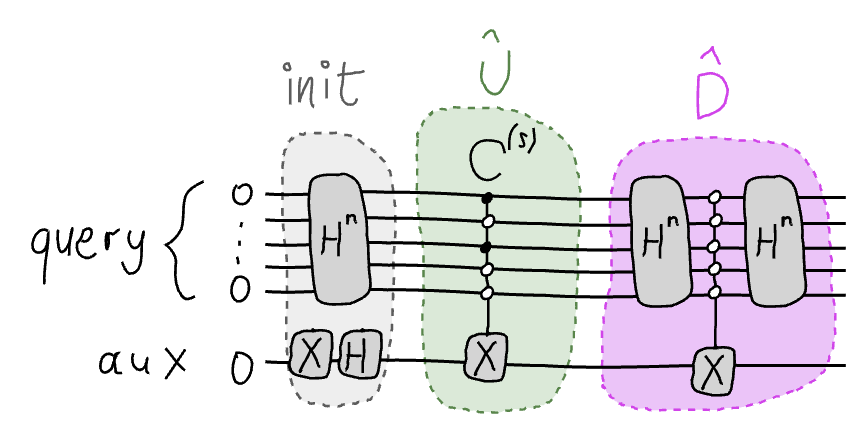**



**Building the diffusion operator**

In [ ]:
def hadamard_transform(my_wires):
    """Apply the Hadamard transform on a given set of wires.

    Args:
        my_wires (list[int]): A list of wires on which the Hadamard transform will act.
    """
    for wire in my_wires:
        qml.Hadamard(wires=wire)


def diffusion():
    """Implement the diffusion operator using the Hadamard transform and
    multi-controlled X."""


    qml.broadcast(unitary=qml.Hadamard, pattern="single", wires=[ i for i in range(5)])
    qml.MultiControlledX(control_wires=query_register, wires=aux, control_values="00000")
    qml.broadcast(unitary=qml.Hadamard, pattern="single", wires=[ i for i in range(5)])


In [ ]:
def hadamard_transform(my_wires):
    """Apply the Hadamard transform on a given set of wires.

    Args:
        my_wires (list[int]): A list of wires on which the Hadamard transform will act.
    """
    for wire in my_wires:
        qml.Hadamard(wires=wire)


def diffusion():
    """Implement the diffusion operator using the Hadamard transform and
    multi-controlled X."""


    hadamard_transform(query_register)
    qml.MultiControlledX(control_wires=query_register, wires=aux, control_values="00000")
    hadamard_transform(query_register)


**Improving the circuit**

In [ ]:
@qml.qnode(dev)
def grover_circuit(combo):
    """Apply the MultiControlledX Grover operator and return probabilities on
    query register.

    Args:
        combo (list[int]): A list of bits representing the secret combination.

    Returns:
        array[float]: Measurement outcome probabilities.
    """

    # PREPARE QUERY AND AUXILIARY SYSTEM
    qml.PauliX(wires=aux)
    hadamard_transform(all_wires)


    # APPLY GROVER ITERATION
    #qml.MultiControlledX(control_wires=query_register, wires=aux, control_values="10100")
    oracle(combo)

    #hadamard_transform(my_wires)

    #qml.MultiControlledX(control_wires=query_register, wires=aux, control_values="00000")

    diffusion()

    return qml.probs(wires=query_register)


**Make a guess**

In [ ]:
def grover_iter(combo, num_steps):
    """Run Grover search for a given secret combination and a number of iterations.

    Args:
        combo (list[int]): The secret combination, represented as a list of bits.
        num_steps (int): The number of Grover iterations to perform.

    Returns:
        array[float]: Probability for observing different outcomes.
    """
    n_bits = len(combo)
    query_register = list(range(n_bits))
    aux = [n_bits]
    all_wires = query_register + aux
    dev = qml.device("default.qubit", wires=all_wires)

    @qml.qnode(dev)
    def inner_circuit():
        qml.PauliX(wires=aux)
        hadamard_transform(all_wires)
        for _ in range(num_steps):
              oracle(combo)
              diffusion(n_bits)

        # IMPLEMENT THE GROVER CIRCUIT
        return qml.probs(wires=query_register)

    return inner_circuit()


**Optimal number of iterations**

In [ ]:
n_list = range(3, 7)
opt_steps = []

for n_bits in n_list:
    combo = "0" * n_bits  # A simple combination
    step_list = range(1, 10)  # Try out some large number of steps

    # Refactored code using list comprehension
    arr = [grover_iter(combo, _)[0].numpy() for _ in step_list]

    # Find the optimal number of steps and append it to opt_steps
    opt_steps.append(local_max_arg(arr))
    pass

print("The optimal number of Grover steps for qubits in", [3, 4, 5, 6], "is", opt_steps, ".")


/usr/local/lib/python3.10/dist-packages/pennylane/ops/op_math/controlled_ops.py:1045: PennyLaneDeprecationWarning: Specifying control values using a bitstring is deprecated, and will not be supported in future releases, Use a list of booleans or integers instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pennylane/ops/op_math/controlled_ops.py:1051: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


ValueError: Length of control values must equal number of control wires.

**Finding the scaling power**

In [ ]:
grad = 0.5
intercept = -0.47
# SUBMIT TO PLOT GRAPH